In [6]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt

from problems import create_3SAT_H_and_psi
import methods

## Linear solver demo

In [9]:
num_qubits = 7

# Load the instances
instances = np.loadtxt("dataset/sat%s.txt"%num_qubits).astype(np.int_)

# Pick the first instance just for demonstrations
H_initial, H_final, psi_initial, psi_final = create_3SAT_H_and_psi(num_qubits,instances[0])

# Solve using the Linear Method
Ts = np.linspace(4, 500, 50)
fidelities = []
energies = []
for T in tqdm.tqdm(Ts):
    energy, fidelity = methods.linear(5, T, H_initial, H_final, psi_initial, psi_final)
    energies.append(energy)
    fidelities.append(fidelity)

100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


/Users/evert/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'energy')

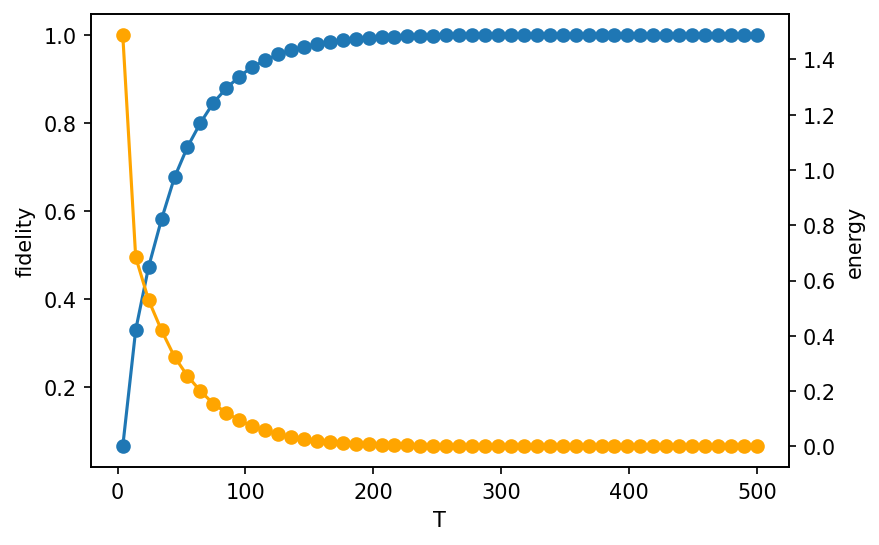

In [13]:
fig, ax = plt.subplots(dpi=150)
ax.plot(Ts, fidelities, '-o')

ax.set_xlabel("T")
ax.set_ylabel("fidelity")

ax2 = ax.twinx()
ax2.plot(Ts, energies, '-o', c='orange')
ax2.set_ylabel("energy")